# Initializations

In [105]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [3]:
%%px --local

import sys
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension


In [4]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = (img - img.min()) / float((img.max() - img.min()))
    return img

# Show stats on one example

First example: Paris, a radial, landlocked city with some lakes around.

In [5]:
myfile_SAR = '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile_POP = '/home/data/world-cities/urban_areas_over_10kpop_log/POP_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile_NLI = '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'

img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
   
mask = (imread(myfile_POP) > 0).astype(np.uint8)
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)

mycity = City(img, name='Paris', mask=mask, sources=["built", "pop", "lum"])

Another example - a coastal city with lots of water around (where nothing can be built)

We would like to compute a mask where no builtup can occur. 
Right now, we chose the regions with 0 population as first pass. This is because the LandScan product has been thoroughly processed to account for water bodies and other places that obviously cannot be populated. We may have to change this in the future. 

In [6]:
myfile_SAR = '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'
myfile_POP = '/home/data/world-cities/urban_areas_over_10kpop_log/POP_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'
myfile_NLI = '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'

img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
    
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)

mask = (imread(myfile_POP) > 0).astype(np.uint8)

mycity = City(img, name='Boston', mask=mask, sources=["built", "pop", "lum"])

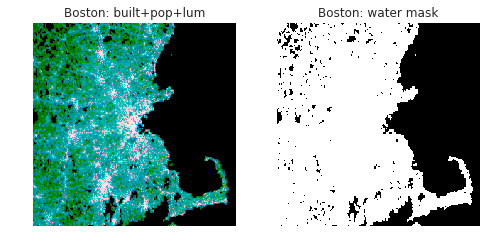

In [7]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(mycity.M); 
ax[0].axis("off"); ax[0].set_title("%s: built+pop+lum" % mycity.name)

ax[1].imshow(np.isnan(mycity.mask)); 
ax[1].axis("off"); ax[1].set_title("%s: water mask" % mycity.name)


#### Fraction of occupied area

In [8]:
mycity.compute_average()
mycity.avg_areas

{'built': 0.11126104943193821,
 'lum': 0.51160499237032697,
 'pop': 0.61502252562058457}

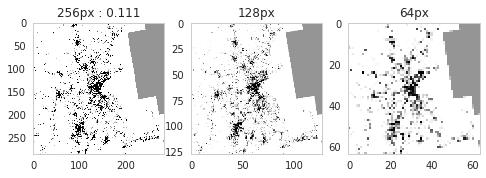

In [9]:
# using skimage

img_64 = resize(img[:,:,0], (64,64), preserve_range=True)
img_128= resize(img[:,:,0], (128,128), preserve_range=True)

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img[:,:,0]); ax[0].set_title("256px : %2.3f"%mycity.avg_areas['built'])
ax[1].imshow(img_128); ax[1].set_title("128px")
ax[2].imshow(img_64); ax[2].set_title("64px")

#### Distribution of patch areas

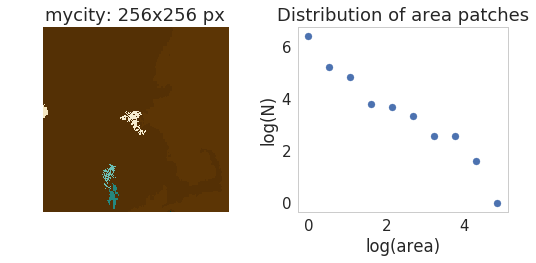

In [10]:
sns.set_context("notebook", font_scale=1.5)

mycity.compute_regions()
areas = mycity.regions['built']
areas_distr, bins = mycity.areas_distr['built'][0], mycity.areas_distr['built'][1]

# plot just top 5 areas
mask1 = mycity.masks_regions['built'].copy()
for a in areas[5:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("mycity: 256x256 px")
ax[0].axis("off")

# plot distribution of area sizes
ax[1].scatter(np.log(bins), areas_distr, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

#### Fractal dimension

('Minkowski-Bouligand dimension (computed): ', 1.5993838379948804)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


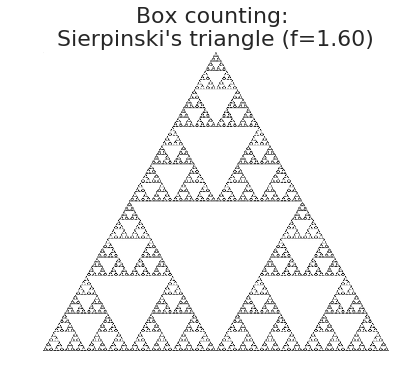

In [11]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
plt.axis("off")
plt.title("Box counting: \nSierpinski's triangle (f=%2.2f)"%fractal_dimension(I)[0], 
          fontsize=22)

print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I)[0])
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [12]:
frac_dim = mycity.compute_fractal_dim(0)
print mycity.fractal_dim

_, log_box_sizes, log_box_counts = fractal_dimension(mycity.M[:,:,0])

{'built': 1.6238314136083782}


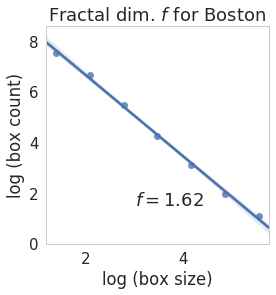

In [13]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(4,4))
ax = sns.regplot(log_box_sizes, log_box_counts, lowess=False)
plt.xlabel("log (box size)")
plt.ylabel("log (box count)")
plt.title("Fractal dim. $f$ for %s" % mycity.name)

ax.annotate('$f=$%.2f'%frac_dim['built'], xy=(2, 1), xytext=(3, 1.5))


#### Compute distance profiles

In [14]:
profiles = mycity.compute_profile()

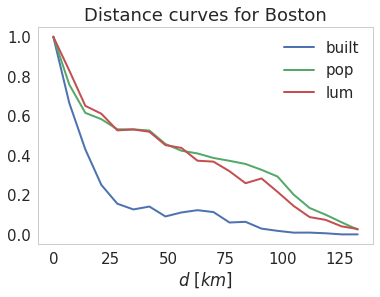

In [15]:
xlabels = np.arange(20) * 10 * 200 / 286.0

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0], label=c, lw=2)
plt.legend(loc="best")
plt.title("Distance curves for %s"%mycity.name)
plt.xlabel("$d \ [km]$")

# Compute spatial stats across all cities

#### Gather all data sources

In [16]:
dataroot = "/home/data/world-cities/"

In [17]:
regions_df = pd.read_csv(dataroot + "countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}


In [18]:
import glob

files = glob.glob(dataroot + "urban_areas_over_10kpop_log/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname = s[-1]
    cls = fname.split("_")[3]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)
files_df['source'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[0])

len(files_df)

125120

In [42]:
files_df.head(2)

,filename,class,country,population,city,region,source
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44071,"saint louis park, us (pop 44.1k)",Americas,SAR
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44174,"pittsfield, us (pop 44.2k)",Americas,SAR


In [43]:
sources = files_df.groupby("city").apply(\
                    lambda x: (x[['city', 'country', 'region', 'population', 'class']].iloc[0].to_dict(), 
                               dict(zip(x['source'], x['filename']))))
filenames = [s[1] for s in sources]
info = [s[0] for s in sources]
print sources[0]

({'city': 'a coruna, es (pop 236.0k)',
  'class': 'medium',
  'country': 'es',
  'population': '236010',
  'region': 'Europe'},
 {'NLI': '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
  'PNM': '/home/data/world-cities/urban_areas_over_10kpop_log/PNM_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
  'POP': '/home/data/world-cities/urban_areas_over_10kpop_log/POP_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
  'PSM': '/home/data/world-cities/urban_areas_over_10kpop_log/PSM_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
  'SAR': '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png'})

#### Compute stats in parallel

In [74]:
%%px --local

import numpy as np

def compute_stats(filenames):
    img = []
    for f in [filenames['SAR'], filenames['POP'], filenames['NLI']]:
        img.append(read_img(f))
    img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
    mask = (imread(filenames['POP']) > 0).astype(np.uint8)
    city = City(img, mask=mask, sources=["bldg", "pop", "lum"])
    try:
        city.analyze()
        return {"profiles":city.profiles, 
                "frac dim":city.fractal_dim, 
                "avg area":city.avg_areas, 
                "area dis":city.areas_distr}
    except:
        return None

In [ ]:
for c in sources[:10]:
    info = compute_stats(c)

In [22]:
%%timeit
info = compute_stats(sources[1])

1 loop, best of 3: 1.24 s per loop


In [75]:
res = lbv.map_async(lambda src: compute_stats(src), filenames)

In [83]:
res.progress

25024

In [89]:
idx_ok = [r is not None for i,r in enumerate(res.result()) ]
tot = dict(zip([i['city'] for i,ok in zip(info, idx_ok) if ok], 
         [dict(i.items() + d.items()) for i,d,ok in zip(info,res.result(), idx_ok) if ok]))

len(idx_ok), sum(idx_ok)

(25024, 24998)

#### Save to file

In [94]:
with gzip.open(dataroot + "stats_25k_cities.pickle.gz", "w") as f:
    pickle.dump(tot, f)

# Analyze spatial statistics over all cities 

In [ ]:
# with gzip.open(dataroot + "stats_25k_cities.pickle.gz", "r") as f:
#     tot = pickle.load(f)

In [112]:
tot.values()[0].keys()

['city',
 'avg area',
 'area dis',
 'country',
 'region',
 'profiles',
 'class',
 'frac dim',
 'population']

Average built area $a$

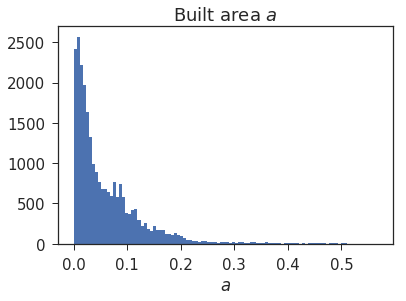

In [121]:
a_sar = np.array([v['avg area']['bldg'] for k,v in tot.iteritems()])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(a_sar, bins=100)
plt.title("Built area $a$")
plt.xlabel("$a$")

Fractal dimension $f$

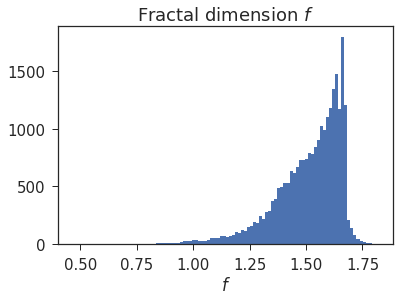

In [120]:
f_sar = np.array([v['frac dim']['bldg'] for k,v in tot.iteritems()])

sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(6,4))
_ = plt.hist(f_sar, bins=100)
plt.title("Fractal dimension $f$")
plt.xlabel("$f$")

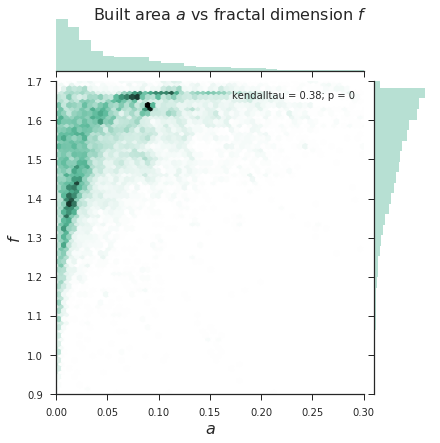

In [124]:

from scipy.stats import kendalltau
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

plt.figure(figsize=(6,4))
g = sns.jointplot(a_sar, f_sar, xlim=(0,0.3), ylim=(0.9,1.7),
              kind="hex", stat_func=kendalltau, color="#4CB391")
g.fig.suptitle("Built area $a$ vs fractal dimension $f$", fontsize=16)
g.ax_joint.set_xlabel("$a$", fontsize=16)
g.ax_joint.set_ylabel("$f$", fontsize=16)